# Transit Photometry Workbook
This workbook will guide you through photometry of the star Wasp-2 in order to produce a transit lightcurve and measure the basic properties of the exoplanet Wasp-2 b.

### Imports
These packages include functions that will do most of the more tedious work for us, such as creating photometric apertures. The next cell includes all imports.

In [2]:
pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 7.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.time import Time
from scipy.optimize import least_squares
from datetime import datetime

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.centroids import centroid_2dg
from photutils.centroids import centroid_sources

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from sow_tools import mask_bad_pix

/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The below cell is the base path where all the files for this project are located. Do not edit.

In [4]:
store_path = 'raw/'

We need to get the names of all the files we will be using. Edit the list definitions below with correct file names and locations.
e.g. bias_files = ['file1.fits', 'file2.fits', etc...]. Find the correct files to use in the observing log from June 19th 2022, available as a .pdf in this assignment folder. 

https://jupyter1.idre.ucla.edu/services/phys180s22/files/phys180s22/source/Wasp-2b%20Transit%20Analysis/Observing%20Log.xlsx%20-%2020220619.pdf

In [5]:
bias_files = ['d1022.fits','d1023.fits','d1024.fits','d1025.fits','d1026.fits',
              'd1027.fits','d1028.fits','d1029.fits','d1030.fits']
flat_files = ['d'+str(x)+'.fits' for x in range(1000,1009)] 
sci_files = ['d'+str(x)+'.fits' for x in range(1075,1155)] # science images of Wasp-2

### Creating main calibrations
We want to average our individual calibration images together to make a main image that is more accurate than any of the individual images. To do this, we will read in the image data from each of our individual calibrations then take the median of every pixel value. It is better to take the median instead of a true average because the median is not changed by one large outlier, while an average is.

### Edit the code below to create a main bias image and save it in the main_bias variable
Reference the data reduction workbook or ask an instructor for help if you aren't sure what to do.

In [6]:
bnum = len(bias_files)
bias_data = np.empty((bnum,1024,1056))
for i,file in enumerate(bias_files):
    bias_data[i] = fits.getdata(store_path+file)
main_bias = np.nanmedian(bias_data,axis=0)

We will now plot the main bias to see what it looks like, no editing required.

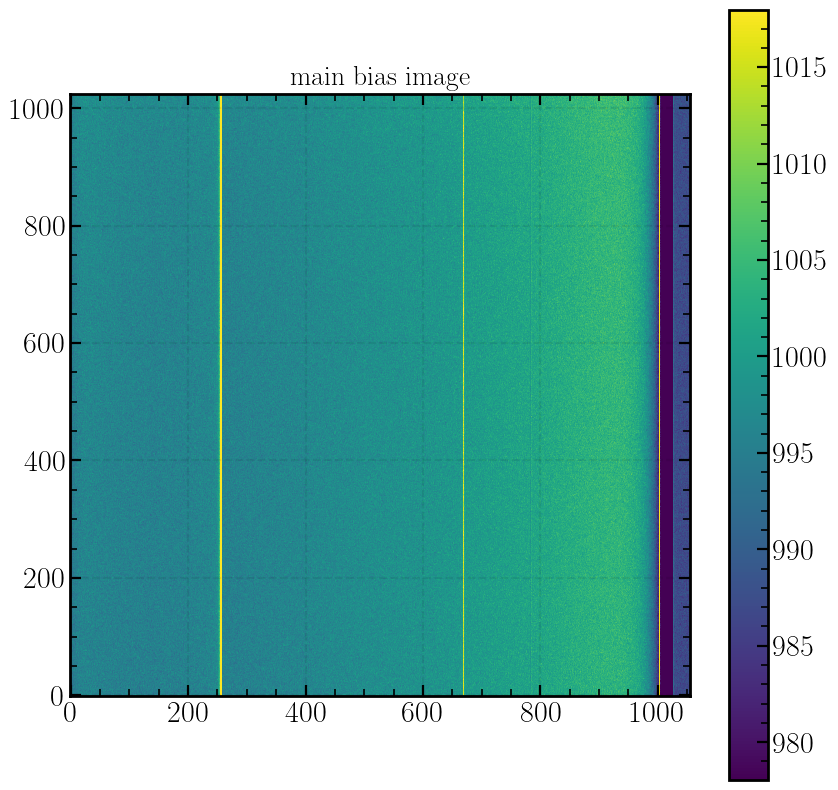

In [10]:
# %matplotlib widget

med_bval = np.nanmedian(main_bias)

plt.figure(figsize=(10,10))
plt.imshow(main_bias, vmin=med_bval*0.98, vmax=med_bval*1.02, origin='lower')
plt.colorbar()
plt.title('main bias image', fontsize=20)
plt.show()

Now do the same but for the flat images. Save the image in the main_flat variable.
Remember that each individual flat image needs the main_bias subtracted from it before they are combined together.

In [8]:
fnum = len(flat_files)
flat_data = np.empty((fnum,1024,1056))
for i,file in enumerate(flat_files):
    flat_data[i] = (fits.getdata(store_path+file) - main_bias) / np.nanmedian(fits.getdata(store_path+file))
main_flat = np.nanmedian(flat_data,axis=0)

Once again we will plot the main flat to see what it looks like:

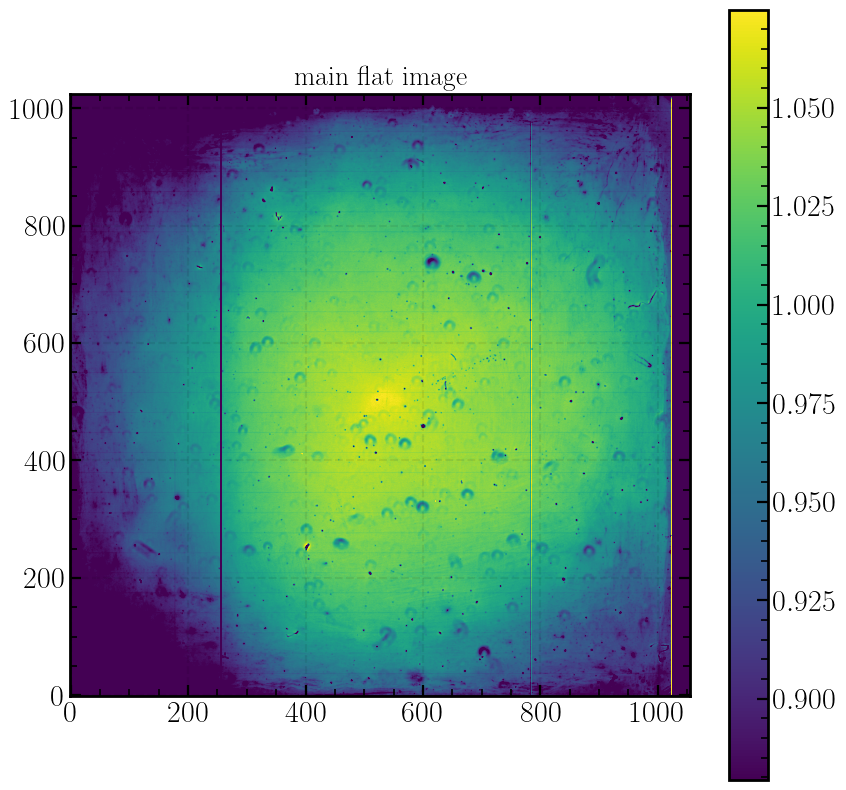

In [9]:
# %matplotlib widget

med_fval = np.nanmedian(main_flat)

plt.figure(figsize=(10,10))
plt.imshow(main_flat, vmin=med_fval*0.9, vmax=med_fval*1.1, origin='lower')
plt.colorbar()
plt.title('main flat image', fontsize=20)
plt.show()

### Correcting our science images with the main calibrations
Here we will use our main bias and main flat images to correct all of the science images. The science images are loaded for you, but you need to input the math for correcting them into the loop. 

In addition, we will use a function **mask_bad_pix** to remove bax pixels and cosmic rays from our science images. This function is already written, you simply need to give it the corrected image as the **sci_im** variable.
At the end of this cell, we save important information from the .fits header, specifically the time that the observations occurred.

In [11]:
num_sci = len(sci_files)
sci_data = np.empty((num_sci,1024,1024))
time_data = []
for i, file in enumerate(sci_files):
    # loop through all science files
    hdu = fits.open(store_path+file)
    
    sci_im = (hdu[0].data - main_bias)/main_flat
    
    # mask_bad_pix will search for significant outliers in our data and remove them, we also remove an unneeded overscan region of the images
    sci_data[i] = mask_bad_pix(sci_im)[0:1024,0:1024]
    
    # write the corrected science files into new .fits files that will be saved
    tmp = fits.PrimaryHDU(sci_data[i], header=hdu[0].header)
    tmpl = fits.HDUList(tmp)
    tmpl.writeto(store_path+file.strip('.fits')+'_calib.fits', overwrite=True)
    tmpl.close()
    
    # get the beginning and end time of each exposure
    time_data.append([Time(hdu[0].header['DATE-BEG'], format='isot', scale='utc'), Time(hdu[0].header['DATE-END'], format='isot', scale='utc')]) 
    
    # close and go to the next image
    hdu.close()

/var/folders/q_/ccql91bd4gb_s9ts1w1b1sp40000gn/T/ipykernel_62188/2362192257.py:8: RuntimeWarning: divide by zero encountered in divide
  sci_im = (hdu[0].data - main_bias)/main_flat
/var/folders/q_/ccql91bd4gb_s9ts1w1b1sp40000gn/T/ipykernel_62188/2362192257.py:8: RuntimeWarning: invalid value encountered in divide
  sci_im = (hdu[0].data - main_bias)/main_flat
/Users/sahilhegde/Documents/code/Observing Workshop/2025/projects2025/Wasp-2b Transit Analysis/sow_tools.py:31: RuntimeWarning: invalid value encountered in subtract
  std_mat[yx[0]:yx[0]+im.shape[0], yx[1]:yx[1]+im.shape[1]] += (im - nebMean_mat.copy()[yx[0]:yx[0]+im.shape[0], yx[1]:yx[1]+im.shape[1]])**2
/Users/sahilhegde/Documents/code/Observing Workshop/2025/projects2025/Wasp-2b Transit Analysis/sow_tools.py:42: RuntimeWarning: invalid value encountered in subtract
  diff = np.abs(nebMeanArr - im) - thresh



Marking bad pixels (may take several minutes)...
481 bad pixels (0.0%) marked as NaN (not counting known bad pixels)

Marking bad pixels (may take several minutes)...
477 bad pixels (0.0%) marked as NaN (not counting known bad pixels)

Marking bad pixels (may take several minutes)...
454 bad pixels (0.0%) marked as NaN (not counting known bad pixels)

Marking bad pixels (may take several minutes)...
507 bad pixels (0.0%) marked as NaN (not counting known bad pixels)

Marking bad pixels (may take several minutes)...
513 bad pixels (0.0%) marked as NaN (not counting known bad pixels)

Marking bad pixels (may take several minutes)...
525 bad pixels (0.0%) marked as NaN (not counting known bad pixels)

Marking bad pixels (may take several minutes)...
471 bad pixels (0.0%) marked as NaN (not counting known bad pixels)

Marking bad pixels (may take several minutes)...
488 bad pixels (0.0%) marked as NaN (not counting known bad pixels)

Marking bad pixels (may take several minutes)...
480 ba

### Marking the target star and comparison stars
To perform photometry of Wasp-2, we need to identify its pixel location within the image. We also need to identify the pixel locations of at least 5 comparison stars within the image that we will also perform photometry on. The photometry from the comparison stars, which presumably do not have any transits occuring, will be used to correct out any non-transit features from our target lightcurve.

In the next cell, we plot one of the science images. Below that, you need to edit the **star_dict** dictionary to contain the positions of the target and at least 5 other comparison stars.

Use the finding chart included with this assignment to identify which star is Wasp-2.

In [ ]:
%matplotlib widget

med_sval = np.nanmedian(sci_data[0])

plt.figure(figsize=(10,10))
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(sci_data[0], vmin=med_sval*0.8, vmax=med_sval*3, origin='lower', cmap='Greys_r')#, norm=norm)
plt.colorbar()
plt.title('science image', fontsize=20)
plt.show()

In [ ]:
star_dict = {'target':(431,430),
            'c1':(675,145),
            'c2':(850,473),
            'c3':(875,577),
            'c4':(594,628),
            'c5':(214,605)}

Now we will refine the centroid positions of the stars using the phoutils package and plot an circular aperture over each one. Make sure that the stars you intended to select have apertures over them! If they do, no action is needed.

In [ ]:
%matplotlib widget

med_sval = np.nanmedian(sci_data[0])

plt.figure(figsize=(10,10))
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(sci_data[0], vmin=med_sval*0.8, vmax=med_sval*3, origin='lower', cmap='Greys_r')#, norm=norm)

for key in star_dict.keys():
    x, y = centroid_sources(sci_data[0], star_dict[key][0], star_dict[key][1], box_size=21,
                        centroid_func=centroid_2dg)
    pos = (x[0],y[0])
    star_dict[key] = pos
    ap = CircularAperture(pos,r=15)
    if key == 'target':
        ap.plot(color='cyan', lw=2,
                label='Photometry aperture')
        plt.text(x+20,y+20, key, color='cyan')
    else:
        ap.plot(color='red', lw=2,
                label='Photometry aperture')
        plt.text(x+20,y+20, key, color='red')
    
plt.colorbar()
plt.title('science image w/ apertures', fontsize=20)
plt.show()    

### Lightcurve photometry
Now we have our target and comparison stars selected, its time to loop through all of our science images and actually do the photometry. 

In the next cell, we will define the aperture and sky annulus sizes we want to use. You should decide what sizes to use based on the aperture plot that the cell will produce. Make your best guess for good values to start, but you may want to experiment with different sizes after you produce the lightcurve to see what values produce the clearest transit in the final lightcurve.

In [ ]:
ap_radius = 12. # units of pixels
ann_rad_in = 20. # units of pixels
ann_rad_out = 25. # units of pixels

%matplotlib widget

med_sval = np.nanmedian(sci_data[0])

plt.figure(figsize=(10,10))
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(sci_data[0], vmin=med_sval*0.8, vmax=med_sval*3, origin='lower', cmap='Greys_r')#, norm=norm)

for key in star_dict.keys():
    pos = star_dict[key]
    x, y = pos[0], pos[1]
    ap = CircularAperture(pos,r=ap_radius)
    ann = CircularAnnulus(pos,r_in=ann_rad_in, r_out=ann_rad_out)
    if key == 'target':
        ap.plot(color='cyan', lw=1,
                label='Photometry aperture')
        ann.plot(color='cyan', lw=1,
                label='Photometry aperture')
        plt.text(x+20,y+20, key, color='cyan')
    else:
        ap.plot(color='red', lw=1,
                label='Photometry aperture')
        ann.plot(color='red', lw=1,
                label='Photometry aperture')
        plt.text(x+20,y+20, key, color='red')
    
plt.colorbar()
plt.title('science image w/ ap+ann', fontsize=20)
plt.show()   

Now we will loop through our science images and get photometry.

In [ ]:
snum = len(sci_data)
phot_dict = {'target':np.empty(snum),
            'c1':np.empty(snum),
            'c2':np.empty(snum),
            'c3':np.empty(snum),
            'c4':np.empty(snum),
            'c5':np.empty(snum)}

for i, data in enumerate(sci_data): 
    for key in phot_dict.keys():
        # refine centroid
        x, y = centroid_sources(data, star_dict[key][0], star_dict[key][1], box_size=21,
                            centroid_func=centroid_2dg)
        pos = (x[0],y[0])
        star_dict[key] = pos
        
        # mask bad pixel locations
        mask = np.ma.masked_invalid(data).mask
        
        ap = CircularAperture(pos,r=ap_radius)
        ann = CircularAnnulus(pos,r_in=ann_rad_in, r_out=ann_rad_out)
        
        ap_sum = aperture_photometry(data, ap, mask=mask)['aperture_sum']
        ann_sum = aperture_photometry(data,ann,mask=mask)['aperture_sum']
        
        bkg_mean = ann_sum / ann.area
        phot = ap_sum - (bkg_mean*ap.area)  
        phot_dict[key][i] = phot
    

### Looking at the raw lightcurves
Why we use comparison stars becomes clear if we now plot the photometry of all our comparison stars together. You should see that all the stars have photometry the follows the same rough trend, but no transit is obviously visible in the target photometry.

The cell below plots the raw lightcurves with offsets in flux so that the lightcurves are not displayed on top of each other.

In [ ]:
# get time of all observations
t = np.empty(len(time_data))
for i in range(len(time_data)):
    tstart = time_data[i][0]
    tend = time_data[i][1]
    t[i] = (((tend-tstart)/2) + tstart).jd

# plot raw lightcurves
%matplotlib widget
plt.figure(figsize=(12,4))
sep = 0
for key in phot_dict.keys():
    plt.plot(t, phot_dict[key]/np.nanmedian(phot_dict[key]) - sep, label=key)
    sep += 0.03 # creates offset between lightcurves so they don't stack on top of each other
    
plt.ylabel('normalized flux')
plt.xlabel('time (julian date)')
plt.legend()
plt.title('raw lightcurves')
plt.show()

### Detrending our lightcurve!

Let's use the comparison lightcurves we plotted above to remove the "trends" in our target lightcurve and reveal the transit. Take a median of the comparison star photometry for every point in time, and divide that median from the target photometry at that time. Save the "detrended" lightcurve in the **detrended** variable. We will then plot the detrended lightcurve below, and you should see a clear transit.

If you do not see a transit, check if any mistakes may have been made on this or previous steps, and ask the instructor for help!

In [ ]:
main_comp = np.empty(len(t))
for i in range(len(t)):
    plist = []
    for key in phot_dict.keys():
        if key != 'target':
            plist.append(phot_dict[key][i] / np.nanmedian(phot_dict[key]))
    main_comp[i] = np.nanmedian(plist)
    
detrended = phot_dict['target'] / np.nanmedian(phot_dict['target']) / main_comp
        
# plot raw lightcurves
%matplotlib widget
plt.figure(figsize=(12,4))
plt.scatter(t, detrended-np.max(detrended)+1, label='target')
    
plt.ylabel('normalized flux')
plt.xlabel('time (julian date)')
plt.legend()
plt.title('detrended lightcurve')
#plt.axes().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both', color='grey', linestyle='--', alpha=0.2)
plt.show()

### Fitting a model to the transit

We see the transit, let's measure its duration and depth so we can understand what kind of planet we are dealing with (a giant planet like Jupiter, or a small planet like Earth). Below, we have written a function that will fit a transit model to the data. You just need to make some initial guesses on when the transit begins and ends.

In [ ]:
time_ig_begin = 2.45975e6 + 0.822 # time ingress begins # units in JD
time_ig_end = 2.45975e6 + 0.835 # time ingress ends
time_eg_begin = 2.45975e6 + 0.875 # time egress begins
time_eg_end = 2.45975e6 + 0.892 # time egress ends

In [ ]:
# piecewise function that creates a trapezoidal transit shape
def transit_model(time, base, depth, t0, duration, ineg_duration):
    # outside transit
    if abs(time-t0)> duration/2+ineg_duration:
        flux = base
    # egress
    elif -(duration/2+ineg_duration)<t0-time<-duration/2:
        flux = base - depth + depth / ineg_duration * (time-(t0+duration/2))
    # ingress
    elif (duration/2+ineg_duration)>t0-time>duration/2:
        flux = base - depth / ineg_duration * (time-(t0-duration/2-ineg_duration))
    # in transit
    elif abs(time-t0)<duration/2:
        flux = base-depth
    
    return flux

In [ ]:
# function the calculates difference between model and data
def residual(g):
    f = []
    for i in t:
        f.append(transit_model(i,base,depth,g[0],g[1],g[2]))

    res = np.sum((f-(detrended))**2)
    return res

In [ ]:
# depth is calculated based on the in transit and out of transit points
base = np.median(detrended[np.where((t<time_ig_begin)|(t>time_eg_end))]) # out of transit flux
it_base = np.median(detrended[np.where((t<time_eg_begin)&(t>time_ig_begin))]) # in transit flux
depth = base-it_base
# error in depth calculated as std error of the mean
depth_err = np.std(detrended[np.where((t<time_eg_begin)&(t>time_ig_begin))])*2**0.5 / len(detrended[np.where((t<time_eg_begin)&(t>time_ig_begin))])**0.5

# these arrays are the initial guesses and bounds for the model parameters
g0 = np.array([(time_eg_end-time_ig_end)/2 + time_ig_end,
               time_eg_end-time_ig_end,
               (time_eg_end-time_eg_begin + time_ig_end-time_ig_begin)/2])
gb = np.array([(time_ig_end,g0[1]/4,g0[2]/4),
               (time_eg_begin,g0[1]*2,g0[2]*2)])

# do the model fitting, may need to adjust diff_step if the guess is being given as the solution
fit = least_squares(residual, g0, bounds=gb, xtol=1e-14, verbose=2, diff_step=[1e-9,1e-3,1e-3])

### Results
The next two boxes print the results of our fit, then displays the model compared to the data. Make sure the results make sense, otherwise you may need to change your guesses on the transit timing. 

In [ ]:
print('transit midpoint:', fit.x[0], 'JD +/-', fit.jac[0][0])
print('duration:', (fit.x[1]+2*fit.x[2]) * 24, 'hours +/-', (fit.jac[0][1]) * 24)
print('depth:', depth*100, '% +/-', depth_err*100)

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(t, detrended, label='data', color='k')
model = []
for i in t:
    model.append(transit_model(i,base,depth,fit.x[0], fit.x[1], fit.x[2]))
plt.plot(t, model, label='best fit')
plt.legend()
plt.show()

### Residuals and noise
After fitting a model to the transit, we want to subtract the model from the data to see if any weird patterns remain that may suggest a bad fit, and to caculate the noise in our data.

The box below plots data - model, and the standard deviation of the result, which is equal to the noise is printed into the plot title.

In [ ]:
plt.figure(figsize=(12,4))
model = []
for i in t:
    model.append(transit_model(i,base,depth,fit.x[0], fit.x[1], fit.x[2]))
    plt.axhline(0)
plt.scatter(t, detrended-model, label='residual', color='k')
plt.legend()
plt.ylim(-np.max(detrended-model)*3,np.max(detrended-model)*3)
plt.title('residuals (1-sigma noise: ' +str(np.round(np.std(detrended-model)*100,3))+'%)')
plt.show()

### Analysis questions
Below are a few questions to answer based on the results. Feel free to create new cells below to do any math for the questions.
***
1. What is the radius of Wasp-2 b? Remember that the transit depth is given by $$\text{depth}=\frac{R_p^2}{R_s^2}$$ where $R_p$ is the planet radius and $R_s$ is the star's radius. The radius of the star Wasp-2 is 0.866$\times$ the radius of our Sun. Compare the radius of Wasp-2 b to the of Earth or Jupiter.
***
2. Given the noise in our lightcurve, what is the smallest planet we could detect? Stated differently, what size planet would give a transit depth equal to the noise? Again, compare the radius of the planet to the radius of Earth or Jupiter.
***
3. Imagine that instead of Wasp-2, we have a much smaller star that only has a radius of 0.12$\times$ the radius of the Sun. What is the smallest planet we could detect then if we had a lightcurve with the same noise? Again, compare the radius of the planet to the radius of Earth or Jupiter.